## MoA (Mechanisms of Action)

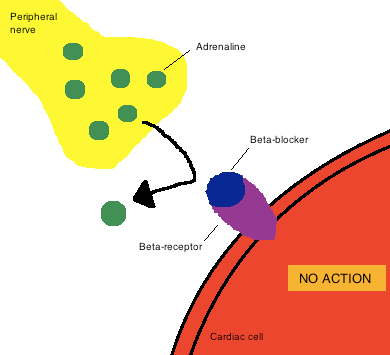
### What is MoA?

According to Widipedia definition In pharmacology, the term mechanism of action (MOA) refers to the specific biochemical interaction through which a drug substance produces its pharmacological effect. A mechanism of action usually includes mention of the specific molecular targets to which the drug binds, such as an enzyme or receptor.

So in simple terms what kind of receptor or enzyme a drug will bind with is called MoA.



## 1. what we have to predict?💡<br/>

so we are given some data related to drug (what data we will see later) and we are given data that particular drug in given row affects which enzymze or receptor etc. There are total 206 different types of receptors given which drug could bind with so 1 represent binding 0 the opposite. 

so our task is to use this data to make a model which could predict to which receptors the unknown drug will bind to.

### Data Provided.

1. **train_features:**<br/>
sig_id: if of each sample<br/>
columns starts with "g-": Gene expression<br/>
columns starts with "c-": Cell Viability<br/>
cp_type: samples treated with compound. - "ctrl_vehicle,<br/> cp_vehicle"<br/>
cp_time: treatment duration (24,48,72)<br/>
dose: high or low<br/>

2. **train_targets_scores**<br/>
sig_id: id of each sample<br/>
and 206 receptors and enzyme which drug might bind with.

3. **test_features**<br/>
same as train features


**If there is any mistake in code or anything please let me know in comments.
and upvote if you like my notebook.😀**

## 2. Metrics: Log-loss 📏

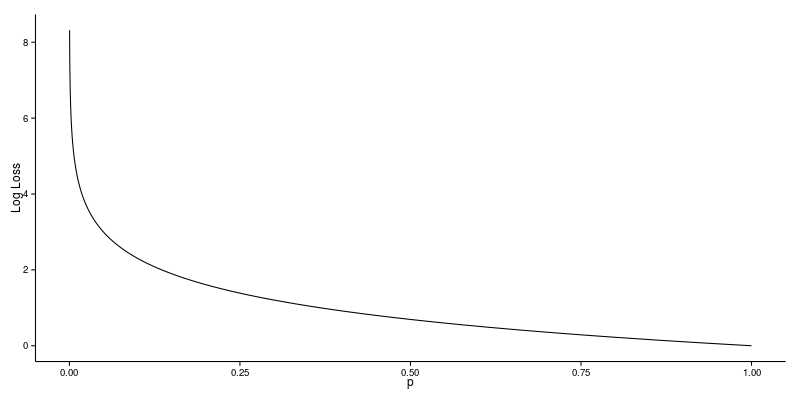

Metrics is simply mean of log-loss for all 206 columns

[evaluation](https://www.kaggle.com/c/lish-moa/overview/evaluation)

### Importing Libraries 📘

In [ ]:
import os
import gc
import tqdm
import random
from typing import Dict

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True,theme='pearl')

import warnings
warnings.filterwarnings('ignore')

from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler,RobustScaler,QuantileTransformer,KBinsDiscretizer,Normalizer
from sklearn.model_selection import  KFold
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset,DataLoader

### Getting data💽

In [ ]:
file_path = "../input/lish-moa/"

train_data = pd.read_csv(file_path+'train_features.csv')
test_data = pd.read_csv(file_path+'test_features.csv')
sample = pd.read_csv(file_path+'sample_submission.csv')
target_data  = pd.read_csv(file_path+'train_targets_scored.csv')


In [ ]:
print(f"{y_}Number of rows in train data: {r_}{train_data.shape[0]}\n{y_}Number of columns in train data: {r_}{train_data.shape[1]}")
print(f"{g_}Number of rows in test data: {r_}{test_data.shape[0]}\n{g_}Number of columns in test data: {r_}{test_data.shape[1]}")
print(f"{m_}Number of rows in target data: {r_}{target_data.shape[0]}\n{m_}Number of columns in target data: {r_}{target_data.shape[1]}")
print(f"{b_}Number of rows in submission data: {r_}{sample.shape[0]}\n{b_}Number of columns in submission data:{r_}{sample.shape[1]}")

In [ ]:
train_data.head().style.applymap(lambda x: 'background-color:lightgreen')

## 3. EDA 📊

### 3.1 Countplot of cp_type 🔢

In [ ]:
def countplot1(feature):
    plt.figure(dpi=100)
    sns.countplot(train_data[feature])
    counts = train_data[feature].value_counts()
    for i in range(len(counts)):
        print(f"{b_}count of {counts.index[i]} is: {r_}{counts.values[i]}")

In [ ]:
countplot1("cp_type")

### 3.2 count of cp_time 🔢

In [ ]:
countplot1("cp_time")

### 3.3 count of cp_dose

In [ ]:
countplot1('cp_dose')

### 3.4 Distribution of single of Gene expression 💊

In [ ]:
def distribution1(feature, color):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    sns.distplot(train_data[feature],color=color)
    plt.subplot(122)
    sns.violinplot(train_data[feature])
    print("{}Max value of {} is: {} {:.2f} \n{}Min value of {} is: {} {:.2f}\n{}Mean of {} is: {}{:.2f}\n{}Standard Deviation of {} is:{}{:.2f}"\
      .format(y_,feature,r_,train_data[feature].max(),g_,feature,r_,train_data[feature].min(),b_,feature,r_,train_data[feature].mean(),m_,feature,r_,train_data[feature].std()))

In [ ]:
distribution1("g-1","blue")

### 3.5 Distribution of mean of Gene expression

In [ ]:
train_data['g_mean'] = train_data[[x for x in train_data.columns if x.startswith("g-")]].mean(axis=1)
test_data['g_mean'] = test_data[[x for x in train_data.columns if x.startswith("g-")]].mean(axis=1)

distribution1("g_mean","yellow")

### 3.6 Distribution of single cell viability

In [ ]:
distribution1("c-0","green")

### 3.7 Distribution of mean of cell viability

In [ ]:
train_data['c_mean'] = train_data[[x for x in train_data.columns if x.startswith("c-")]].mean(axis=1)
test_data['c_mean'] = test_data[[x for x in train_data.columns if x.startswith("c-")]].mean(axis=1)

distribution1('c_mean','orange')

### 3.8 Distribution of g_mean based on cp_type,cp_time, cp_dose

In [ ]:
def distribution2(feature):
    plt.figure(figsize=(15,14))
    plt.subplot(231)
    for i in train_data.cp_type.unique():
        sns.distplot(train_data[train_data['cp_type']==i][feature],label=i)
    plt.title(f"{feature} based on cp_type")
    plt.legend()

    plt.subplot(232)
    for i in train_data.cp_time.unique():
        sns.distplot(train_data[train_data['cp_time']==i][feature],label=i)
    plt.title(f" {feature}  based on cp_time")
    plt.legend()
    
    plt.subplot(233)
    for i in train_data.cp_dose.unique():
        sns.distplot(train_data[train_data['cp_dose']==i][feature],label=i)
    plt.title(f" {feature} based on cp_dose ")
    
    plt.subplot(234)
    sns.violinplot(data=train_data,y=feature,x='cp_type')
    plt.title(f"{feature} based on cp_type")
    plt.legend()

    plt.subplot(235)
    sns.violinplot(data=train_data,y=feature,x='cp_time')
    plt.title(f" {feature}  based on cp_time")
    plt.legend()
    
    plt.subplot(236)
    sns.violinplot(data=train_data,y=feature,x='cp_dose')
    plt.title(f" {feature} based on cp_dose ")
    plt.legend()

In [ ]:
distribution2('g_mean')

### 3.9 Distribution of c_mean based on cp_type,cp_time, cp_dose

In [ ]:
distribution2('c_mean')

### 3.10 Gene exp of 4 random samples

In [ ]:
g_cols = [x for x in train_data.columns if x.startswith("g-")]
c_cols = [x for x in train_data.columns if x.startswith("c-")]

In [ ]:
def plot1(features):
    rnd = np.random.randint(0,train_data.shape[0]-16)
    plt.figure(figsize=(10,7))
    
    for i in range(4):
        data = train_data.loc[rnd+i,features]
        mean = np.mean(data.values)
        plt.subplot(2,2,i+1)
        sns.scatterplot(data=data.values,marker=">") 
        plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,    
        top=False,        
        labelbottom=False)
        sns.lineplot(x=list(range(len(data))), y = [mean]*len(data),color='r',linewidth=2)
        
    plt.show()

In [ ]:
plot1(g_cols)

### 3.11 cell validity of 4 random sample

In [ ]:
plot1(c_cols)

### 3.12 Heat map of n random gene exp columns

In [ ]:
def heat(n):
    plt.figure(figsize=(13,13))
    rnd = np.random.randint(0,len(g_cols)-n)
    data = train_data[g_cols]
    data = data.iloc[:,rnd:rnd+n]
    sns.heatmap(data.corr())
    plt.show()

In [ ]:
heat(30)

### 3.13 Count of top 50 targets

In [ ]:
df = target_data.iloc[:,1:].sum(axis=0).sort_values(ascending=True)[-50:]
fig = px.bar(x=df.values,y = df.index,color=df.values)
fig.show()


### 3.14 count of lowest 50 target

In [ ]:
df = target_data.iloc[:,1:].sum(axis=0).sort_values(ascending=True)[:50]
fig = px.bar(x=df.values,y = df.index,color=df.values)
fig.show()

Let's try to find if gene expression and cell viability of higher count are different from one with lower

In [ ]:
data = train_data.merge(target_data,on='sig_id')
top_50 = target_data.drop("sig_id",axis=1).columns[target_data.iloc[:,1:].sum(axis=0)>=89]
bottom_50 = target_data.drop("sig_id",axis=1).columns[target_data.iloc[:,1:].sum(axis=0)<=19]
data_top_50 = data[data[top_50].any(axis=1)][g_cols]
data_bottom_50  = data[data[bottom_50].any(axis=1)][g_cols]

### 3.15 Plot of mean of gene exp for top 50

In [ ]:
plt.figure(dpi=100)
sns.distplot(data_top_50.mean(axis=1),color='yellow')
plt.show()

### 3.16 random 4 gene exp from top 50

In [ ]:
def plot2(df):
    rnd = np.random.randint(0,df.shape[0]-5)
    plt.figure(figsize=(10,7))
    
    for i in range(4):
        data = df.iloc[rnd+i,:]
        mean = np.mean(data.values)
        plt.subplot(2,2,i+1)
        sns.scatterplot(data=data.values,marker=">") 
        plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,    
        top=False,        
        labelbottom=False)
        sns.lineplot(x=list(range(len(data))), y = [mean]*len(data),color='r',linewidth=2)
        
    plt.show()

In [ ]:
plot2(data_top_50)

### 3.17 Plot of mean of gene exp for top 50

In [ ]:
plt.figure(dpi=100)
sns.distplot(data_bottom_50.mean(axis=1),color='yellow')
plt.show()

### 3.18 random 4 gene exp from bottom 50

In [ ]:
plot2(data_bottom_50)

### 3.19 Top 50 sample with highest count of target

In [ ]:
df = target_data.iloc[:,1:].sum(axis=1).sort_values(ascending=True)[-50:]
fig = px.bar(x=df.values,y = target_data.sig_id[df.index],color=df.values)
fig.show()

In [ ]:
print("Number of samples with zero target counts are: ",np.sum(target_data.iloc[:,1:].sum(axis=1) == 0))

## Visulisation of g_cols using PCA

### 3.20 How good is top 4 pca data of g_cols at seprating our top targets
#### 3.20.1 proteasome_inhibitor

In [ ]:
def pca_plot1(features,n_components,target):
    pca = PCA(n_components=n_components)
    train_g_pca = pca.fit_transform(train_data[features])

    total_var = pca.explained_variance_ratio_.sum()*100
    labels = {str(i): f"PC {i+1}" for i in range(n_components)}

    fig = px.scatter_matrix(
        train_g_pca,
        dimensions=range(n_components),
        labels=labels,
        title=f"Total explained variance ratio{total_var:.2f}%",
        color=target_data[target].values
    )

    fig.update_traces(diagonal_visible=True,opacity=0.5)
    fig.show()


In [ ]:
#you can get top targets using from above graphs
pca_plot1(g_cols,4,"proteasome_inhibitor")

#### 3.20.2 dopamine_receptor_antagonist

In [ ]:
pca_plot1(g_cols,4,"dopamine_receptor_antagonist")

#### 30.20.3 dna_inhibitor

In [ ]:
pca_plot1(g_cols,4,"dna_inhibitor")

### 3.21 How good is top 4 pca data of c_cols at seprating our top targets
#### 3.21.1 proteasome_inhibitor

In [ ]:
pca_plot1(c_cols,4,"proteasome_inhibitor")

#### 3.21.2 dopamine_receptor_antagonist

In [ ]:
pca_plot1(c_cols,4,"dopamine_receptor_antagonist")

#### 3.21.3 dna_inhibitor

In [ ]:
pca_plot1(c_cols,4,"dna_inhibitor")

### 3.22 Pca plot 3d (g_cols)
#### 3.22.1 proteasome_inhibitor

In [ ]:
def pca_plot_3d(features,target):
    pca = PCA(n_components=3)
    train_g_pca = pca.fit_transform(train_data[features])

    total_var = pca.explained_variance_ratio_.sum()*100

    fig = px.scatter_3d(
        train_g_pca,x=0,y=1,z=2,
        title=f"Total explained variance ratio{total_var:.2f}%",
        color=target_data[target].values,
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
    )

    fig.show() 

In [ ]:
pca_plot_3d(g_cols,"proteasome_inhibitor")

#### 3.22.2 dopamaine_receptor_antagonist

In [ ]:
pca_plot_3d(g_cols,"dopamine_receptor_antagonist")

#### 3.22.3 dna_inhibitor

In [ ]:
pca_plot_3d(g_cols,"dna_inhibitor")

### 3.23 Pca plot 3d (c_cols)
#### 3.23.1 proteasome_inhibitor

In [ ]:
pca_plot_3d(c_cols,"proteasome_inhibitor")

#### 3.23.2 dopamine_receptor_antagonist

In [ ]:
pca_plot_3d(c_cols,"dopamine_receptor_antagonist")

#### 3.23.3 dna_inhibitor

In [ ]:
pca_plot_3d(c_cols,"dna_inhibitor")

### 3.24 Ploting explained variance (g_cols)

In [ ]:
def plot_exp_var(features):
    pca = PCA()
    pca.fit(train_data[features])
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    fig = px.area(
        x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"},
    )
    fig.show()

In [ ]:
plot_exp_var(g_cols)

### 3.25 Ploting explained variance (c_cols)

In [ ]:
plot_exp_var(c_cols)

## 4. Preprocessing Data 📐

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
ignore_columns = ['sig_id','cp_type']

train_columns = [x for x in train_data.columns if x not in ignore_columns]

train = train_data[train_columns]
test = test_data[train_columns]
target = target_data.iloc[:,1:].values

#droping high correlated features
# corr_mat = train.corr().abs()
# upper = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column]>0.80)]
# train = train.drop(to_drop,axis=1)
# test = test.drop(to_drop,axis=1)

# preprocessing
transform = ColumnTransformer([('o',OneHotEncoder(),[0,1]),('s',Normalizer(),list(range(3,train.shape[1])))])
train = transform.fit_transform(train)
test = transform.transform(test)

# transform = ColumnTransformer([('o',OneHotEncoder(),[0,1])],remainder='passthrough')
# train = transform.fit_transform(train)
# test = transform.transform(test)

#using feature union
# transforms = list()
# transforms.append(('ss', Normalizer()))
# transforms.append(('pca', PCA(n_components=100)))

# fu = FeatureUnion(transforms)
# train = fu.fit_transform(train)
# test = fu.transform(test)

In [ ]:
train.shape

## 5. Pytorch baseline model

In [ ]:
class Model(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        super(Model,self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(input_size)
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.utils.weight_norm(nn.Linear(input_size,hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.6)
        self.linear2 = nn.utils.weight_norm(nn.Linear(hidden_size,hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.6)
        self.linear3 = nn.utils.weight_norm(nn.Linear(hidden_size,output_size))
        
    def forward(self,xb):
        x = self.batch_norm1(xb)
        x = self.dropout1(x)
        x = F.leaky_relu(self.linear1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.linear2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        return self.linear3(x)

In [ ]:
def run(plot_losses=False):
  
    def train_loop(train_loader,model,loss_fn,device,optimizer,lr_scheduler=None):
        model.train()
        total_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs,targets)
            loss.backward()
                
            total_loss += loss.item()

            optimizer.step()
            if lr_scheduler != None:
                lr_scheduler.step()
                    
        total_loss /= len(train_loader)
        return total_loss
    
    def valid_loop(valid_loader,model,loss_fn,device):
        model.eval()
        total_loss = 0
        predictions = list()
        
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)                 

            loss = loss_fn(outputs,targets)
            predictions.extend(outputs.sigmoid().detach().cpu().numpy())
            
            total_loss += loss.item()
        total_loss /= len(valid_loader)
            
        return total_loss,np.array(predictions)    
    
    NFOLDS =10
    kfold = MultilabelStratifiedKFold(n_splits=NFOLDS)
    
    #for storing losses of every fold
    fold_train_losses = list()
    fold_valid_losses = list()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    #kfold
    for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train,y=target)):
      
        x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]
        
        input_size = x_train.shape[1]
        output_size = target.shape[1]
        hidden_size = 1024

        model = Model(input_size,output_size,hidden_size)
        model.to(device)
        
        batch_size = 128
        epochs = 30
        lr = 0.01
        
        train_tensor = torch.tensor(x_train,dtype=torch.float)
        y_train_tensor = torch.tensor(y_train,dtype=torch.float)

        train_ds = TensorDataset(train_tensor,y_train_tensor)
        train_dl = DataLoader(train_ds,
                             batch_size = batch_size,
                             shuffle=True
                             )

        valid_tensor = torch.tensor(x_valid,dtype=torch.float)
        y_valid_tensor = torch.tensor(y_valid,dtype=torch.float)

        valid_ds = TensorDataset(valid_tensor,y_valid_tensor)
        valid_dl = DataLoader(valid_ds,
                             batch_size = batch_size,
                             shuffle=False
                             )
        
        optimizer = optim.Adam(model.parameters(),lr=lr)

        lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=epochs, steps_per_epoch=len(train_dl))
        
        print(f"Fold {k}")
        best_loss = 999
        
        train_losses = list()
        valid_losses = list()
        
        for i in range(epochs):
            train_loss = train_loop(train_dl,model,loss_fn,device,optimizer,lr_scheduler)
            valid_loss,predictions = valid_loop(valid_dl,model,loss_fn,device)
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
                          
            print(f"epoch:{i} Training | loss:{train_loss}  Validation | loss:{valid_loss}  ")
            
            if valid_loss <= best_loss:
                print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")
                best_loss = valid_loss
                torch.save(model.state_dict(),f'model{k}.bin')
                
        fold_train_losses.append(train_losses)
        fold_valid_losses.append(valid_losses)
        
        
    if plot_losses == True:
        plt.figure(figsize=(20,14))
        for i, (t,v) in enumerate(zip(fold_train_losses,fold_valid_losses)):
            plt.subplot(2,5,i+1)
            plt.title(f"Fold {i}")
            plt.plot(t,label="train_loss")
            plt.plot(v,label="valid_loss")
            plt.legend()
        plt.show()      

In [ ]:
run(plot_losses=True)

In [ ]:
def inference():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    nfold = 10
    all_prediction = np.zeros((test.shape[0],206))
    
    for i in range(nfold):
        
        input_size = train.shape[1]
        output_size = target.shape[1]
        hidden_size = 1024
        model = Model(input_size,output_size,hidden_size)
        model.load_state_dict(torch.load(f"model{i}.bin"))
        
        predictions = list()
        model.to(device)
        test_tensor = torch.tensor(test,dtype=torch.float)
        test_dl = DataLoader(test_tensor,
                        batch_size=64,
                        shuffle=False)
    
        with torch.no_grad():
            for i, inputs in enumerate(test_dl):
                inputs = inputs.to(device, dtype=torch.float)
                outputs= model(inputs) 
                predictions.extend(outputs.sigmoid().cpu().detach().numpy())

        all_prediction += np.array(predictions)/nfold
        
    return all_prediction  

In [ ]:
predictions = inference()
sample.iloc[:,1:] = predictions
sample.to_csv('submission.csv',index=False)

In [ ]:
sample.head()